In [20]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [21]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [22]:


# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)


# Parâmetros adicionais
t = 14
d = 1
e = 14
# Lista de parâmetros n para iterar
n_list = [1 , 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]  # Exemplo de diferentes valores de n
alpha = 0.01  # Mantemos um único valor de alpha



price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 1
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Loop para calcular o RSI para cada valor em 'n_list'
for n in n_list:
    # Dias de alta e dias de baixa
    up_df, down_df = price_data[['Ticker', 'change_in_price']].copy(), price_data[['Ticker', 'change_in_price']].copy()

    # Salvando a diferença para dias de alta
    up_df.loc[up_df['change_in_price'] < 0, 'change_in_price'] = 0

    # Salvando a diferença para dias de baixa
    down_df.loc[down_df['change_in_price'] > 0, 'change_in_price'] = 0

    # Colocando as diferenças do dia de baixa em termos absolutos
    down_df['change_in_price'] = down_df['change_in_price'].abs()

    # Calculando o EWMA (Exponential Weighted Moving Average) para dias de alta e baixa
    ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span=n).mean())
    ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span=n).mean())

    # Calculando o Relative Strength (RS)
    relative_strength = ewma_up / ewma_down

    # Calculando o Relative Strength Index (RSI)
    relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

    # Salvando o RSI como uma nova coluna no dataframe
    price_data[f'RSI_{n}'] = relative_strength_index

    # Salvando colunas auxiliares para verificação (opcional)
    price_data[f'down_days_{n}'] = down_df['change_in_price']
    price_data[f'up_days_{n}'] = up_df['change_in_price']


# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Criação das variáveis low_t e high_t
low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
# Cálculo dos valores mínimos e máximos baseados na janela t
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

# Cálculo do k_percent
k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))


# Armazenando os resultados no DataFrame com nomes dinâmicos
price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent


# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
price_data[f'r_percent_{t}'] = r_percent

# Price Rate of Change
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd



# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()

price_data.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,RSI_1,down_days_1,up_days_1,RSI_2,down_days_2,up_days_2,RSI_3,down_days_3,up_days_3,RSI_4,down_days_4,up_days_4,RSI_5,down_days_5,up_days_5,RSI_6,down_days_6,up_days_6,RSI_7,down_days_7,up_days_7,RSI_8,down_days_8,up_days_8,RSI_9,down_days_9,up_days_9,RSI_10,down_days_10,up_days_10,RSI_11,down_days_11,up_days_11,RSI_12,down_days_12,up_days_12,RSI_13,down_days_13,up_days_13,RSI_14,down_days_14,up_days_14,RSI_15,down_days_15,up_days_15,RSI_16,down_days_16,up_days_16,RSI_17,down_days_17,up_days_17,RSI_18,down_days_18,up_days_18,RSI_19,down_days_19,up_days_19,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,Price_Rate_Of_Change,MACD,MACD_EMA,On Balance Volume,Close_10
11769,2025-01-07,52.630001,52.889999,51.939999,52.049999,52.049999,22070200,VALE3.SA,-0.510002,60.726555,-1.0,0.0,0.510002,0.000000,0.052756,0.510002,0.000000,0.663843,0.510002,0.000000,2.060868,0.510002,0.000000,3.947204,0.510002,0.000000,6.030658,0.510002,0.000000,8.132696,0.510002,0.000000,10.156730,0.510002,0.000000,12.055145,0.510002,0.000000,13.808865,0.510002,0.000000,15.415102,0.510002,0.000000,16.879914,0.510002,0.000000,18.213716,0.510002,0.000000,19.428651,0.510002,0.000000,20.537094,0.510002,0.000000,21.550853,0.510002,0.000000,22.480789,0.510002,0.000000,23.336660,0.510002,0.000000,24.127106,0.510002,0.000000,52.049999,1.0,51.939999,56.709999,184.204509,84.204509,-0.015481,-0.343412,-0.305602,6199711036,54.020000
11770,2025-01-08,52.029999,52.290001,51.430000,51.549999,51.549999,24423800,VALE3.SA,-0.500000,60.634789,-1.0,0.0,0.500000,0.000000,0.019281,0.500000,0.000000,0.358159,0.500000,0.000000,1.306601,0.500000,0.000000,2.742037,0.500000,0.000000,4.452849,0.500000,0.000000,6.278577,0.500000,0.000000,8.114481,0.500000,0.000000,9.896402,0.500000,0.000000,11.588101,0.500000,0.000000,13.171986,0.500000,0.000000,14.642410,0.500000,0.000000,16.000971,0.500000,0.000000,17.253360,0.500000,0.000000,18.407321,0.500000,0.000000,19.471386,0.500000,0.000000,20.454117,0.500000,0.000000,21.363681,0.500000,0.000000,22.207632,0.500000,0.000000,51.549999,1.0,51.430000,56.540001,180.132830,80.132830,-0.016040,-0.355839,-0.315650,6175287236,52.660000
11771,2025-01-09,52.049999,52.250000,51.139999,51.230000,51.230000,15865200,VALE3.SA,-0.320000,60.540741,-1.0,0.0,0.320000,0.000000,0.008692,0.320000,0.000000,0.225341,0.320000,0.000000,0.939735,0.320000,0.000000,2.120500,0.320000,0.000000,3.607236,0.320000,0.000000,5.256038,0.320000,0.000000,6.962503,0.320000,0.000000,8.656317,0.320000,0.000000,10.293231,0.320000,0.000000,11.847924,0.320000,0.000000,13.308147,0.320000,0.000000,14.670222,0.320000,0.000000,15.935783,0.320000,0.000000,17.109533,0.320000,0.000000,18.197758,0.320000,0.000000,19.207387,0.320000,0.000000,20.145409,0.320000,0.000000,21.018537,0.320000,0.000000,51.230000,1.0,51.139999,56.400002,178.721253,78.721253,-0.016641,-0.369022,-0.326324,6159422036,52.320000
11772,2025-01-10,51.540001,52.310001,51.230000,51.520000,51.520000,25833900,VALE3.SA,0.290001,60.450534,-1.0,100.0,0.000000,0.290001,59.893476,0.000000,0.290001,40.331194,0.000000,0.290001,30.439873,0.000000,0.290001,25.176036,0.000000,0.290001,22.322877,0.000000,0.290001,20.835055,0.000000,0.290001,20.168000,0.000000,0.290001,20.010749,0.000000,0.290001,20.173338,0.000000,0.290001,20.534827,0.000000,0.290001,21.016566,0.000000,0.290001,21.566983,0.000000,0.290001,22.152280,0.000000,0.290001,22.750465,0.000000,0.290001,23.347435,0.000000,0.290001,23.934354,0.000000,0.290001,24.505902,0.000000,0.290001,25.059088,0.000000,0.290001,51.520000,1.0,51.139999,55.869999,196.840068,96.840068,-0.017236,-0.382341,-0.337527,6133588136,53.029999
11773,2025-01-13,52.000000,52.310001,50.869999,51.509998,51.509998,30845300,VALE3.SA,-0.010002,60.361128,-1.0,0.0,0.010002,0.000000,56.398558,0.010002,0.000000,39.243081,0.010002,0.000000,29.927557,0.010002,0.000000,24.872929,0.010002,0.000000,22.115539,0.010002,0.000000,

In [23]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,RSI_1,down_days_1,up_days_1,RSI_2,down_days_2,up_days_2,RSI_3,down_days_3,up_days_3,RSI_4,down_days_4,up_days_4,RSI_5,down_days_5,up_days_5,RSI_6,down_days_6,up_days_6,RSI_7,down_days_7,up_days_7,RSI_8,down_days_8,up_days_8,RSI_9,down_days_9,up_days_9,RSI_10,down_days_10,up_days_10,RSI_11,down_days_11,up_days_11,RSI_12,down_days_12,up_days_12,RSI_13,down_days_13,up_days_13,RSI_14,down_days_14,up_days_14,RSI_15,down_days_15,up_days_15,RSI_16,down_days_16,up_days_16,RSI_17,down_days_17,up_days_17,RSI_18,down_days_18,up_days_18,RSI_19,down_days_19,up_days_19,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,Price_Rate_Of_Change,MACD,MACD_EMA,On Balance Volume,Close_10
5736,2025-01-07,11.30,11.58,11.27,11.54,11.54,34905200,ABEV3.SA,0.25,12.685903,-1.0,100.0,0.00,0.25,82.485196,0.00,0.25,65.504804,0.00,0.25,53.734514,0.00,0.25,45.601738,0.00,0.25,39.885231,0.00,0.25,35.855676,0.00,0.25,33.047523,0.00,0.25,31.136369,0.00,0.25,29.884576,0.00,0.25,29.115062,0.00,0.25,28.695774,0.00,0.25,28.528713,0.00,0.25,28.541568,0.00,0.25,28.681244,0.00,0.25,28.908907,0.00,0.25,29.196245,0.00,0.25,29.522684,0.00,0.25,29.873322,0.00,0.25,11.54,-1.0,11.21,13.42,66.782917,-33.217083,-0.006103,0.004685,0.016018,-6146540023,11.25
5737,2025-01-08,11.48,11.53,11.28,11.42,11.42,39248800,ABEV3.SA,-0.12,12.673244,-1.0,0.0,0.12,0.00,37.702798,0.12,0.00,40.225933,0.12,0.00,37.634682,0.12,0.00,34.467123,0.12,0.00,31.702136,0.12,0.00,29.540696,0.12,0.00,27.968963,0.12,0.00,26.905881,0.12,0.00,26.254432,0.12,0.00,25.922610,0.12,0.00,25.831504,0.12,0.00,25.917144,0.12,0.00,26.129481,0.12,0.00,26.430271,0.12,0.00,26.790787,0.12,0.00,27.189722,0.12,0.00,27.611446,0.12,0.00,28.044617,0.12,0.00,11.42,-1.0,11.21,13.42,66.210111,-33.789889,-0.007341,0.000115,0.012837,-6185788823,11.02
5738,2025-01-09,11.43,11.51,11.30,11.40,11.40,24470100,ABEV3.SA,-0.02,12.660511,-1.0,0.0,0.02,0.00,29.653068,0.02,0.00,35.641089,0.02,0.00,34.743045,0.02,0.00,32.484155,0.02,0.00,30.253789,0.02,0.00,28.428045,0.02,0.00,27.077280,0.02,0.00,26.165226,0.02,0.00,25.620456,0.02,0.00,25.366316,0.02,0.00,25.333423,0.02,0.00,25.463882,0.02,0.00,25.711601,0.02,0.00,26.040975,0.02,0.00,26.425065,0.02,0.00,26.843804,0.02,0.00,27.282439,0.02,0.00,27.730255,0.02,0.00,11.40,-1.0,11.21,13.19,73.258150,-26.741850,-0.008395,-0.004483,0.009373,-6210258923,11.05
5739,2025-01-10,11.40,11.43,11.08,11.16,11.16,31277300,ABEV3.SA,-0.24,12.645506,-1.0,0.0,0.24,0.00,3.413896,0.24,0.00,9.541463,0.24,0.00,13.696425,0.24,0.00,15.958383,0.24,0.00,17.116637,0.24,0.00,17.738416,0.24,0.00,18.149906,0.24,0.00,18.518749,0.24,0.00,18.919909,0.24,0.00,19.378189,0.24,0.00,19.893598,0.24,0.00,20.455565,0.24,0.00,21.050384,0.24,0.00,21.664786,0.24,0.00,22.287410,0.24,0.00,22.909196,0.24,0.00,23.523284,0.24,0.00,24.124706,0.24,0.00,11.16,-1.0,11.08,13.08,78.275302,-21.724698,-0.009828,-0.009231,0.005653,-6241536223,10.87
5740,2025-01-13,11.18,11.31,11.12,11.24,11.24,28945300,ABEV3.SA,0.08,12.631451,-1.0,100.0,0.00,0.08,48.757210,0.00,0.08,39.215880,0.00,0.08,35.427813,0.00,0.08,33.000757,0.00,0.08,31.082232,0.00,0.08,29.517568,0.00,0.08,28.283449,0.00,0.08,27.363409,0.00,0.08,26.727115,0.00,0.08,26.334189,0.00,0.08,26.141324,0.00,0.08,26.107450,0.00,0.08,26.196436,0.00,0.08,26.378000,0.00,0.08,26.627587,0.00,0.08,26.925745,0.00,0.08,27.257330,0.00,0.08,27.610711,0.00,0.08,11.24,-1.0,11.08,12.91,84.778745,-15.221255,-0.010920,-0.013967,0.001729,-6270481523,10.91


n: 1
Fold 1:
 - Correct Prediction (y_test): 88.91%
 - Correct Prediction (Verify): 56.20%
Fold 2:
 - Correct Prediction (y_test): 88.70%
 - Correct Prediction (Verify): 57.07%
Fold 3:
 - Correct Prediction (y_test): 74.24%
 - Correct Prediction (Verify): 50.43%
Fold 4:
 - Correct Prediction (y_test): 88.48%
 - Correct Prediction (Verify): 48.26%
Fold 5:
 - Correct Prediction (y_test): 84.24%
 - Correct Prediction (Verify): 44.78%
Média de acurácia (y_test) para n 1: 84.91%
Média de acurácia (Verify) para n 1: 51.35%
---
n: 2
Fold 1:
 - Correct Prediction (y_test): 90.33%
 - Correct Prediction (Verify): 56.52%
Fold 2:
 - Correct Prediction (y_test): 91.63%
 - Correct Prediction (Verify): 57.17%
Fold 3:
 - Correct Prediction (y_test): 76.09%
 - Correct Prediction (Verify): 50.76%
Fold 4:
 - Correct Prediction (y_test): 90.76%
 - Correct Prediction (Verify): 49.02%
Fold 5:
 - Correct Prediction (y_test): 87.28%
 - Correct Prediction (Verify): 45.43%
Média de acurácia (y_test) para n 2: 8

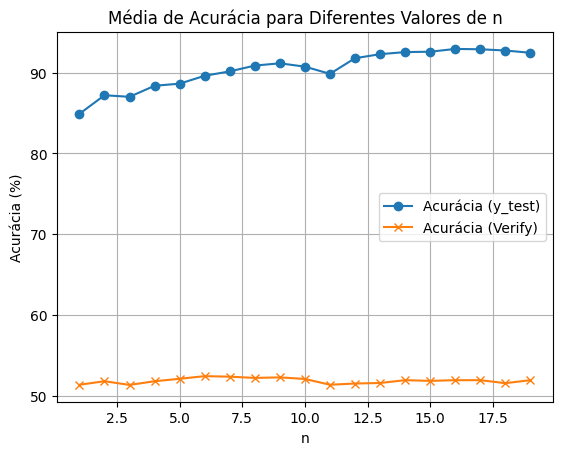

In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

# Loop para cada n em n_list e realização de validação cruzada em série temporal
for n in n_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[[f'RSI_{n}',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    'Price_Rate_Of_Change',
                    'MACD',
                    'MACD_EMA',
                    f'On Balance Volume']]
    y = price_data[f'Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)


#### Caso apareça erro float 32

n: 2
Fold 1:
 - Correct Prediction (y_test): 41.99%
 - Correct Prediction (Verify): 41.77%
Fold 2:
 - Correct Prediction (y_test): 46.37%
 - Correct Prediction (Verify): 47.12%
Fold 3:
 - Correct Prediction (y_test): 53.85%
 - Correct Prediction (Verify): 53.31%
Fold 4:
 - Correct Prediction (y_test): 49.04%
 - Correct Prediction (Verify): 49.68%
Fold 5:
 - Correct Prediction (y_test): 49.15%
 - Correct Prediction (Verify): 47.76%
Média de acurácia (y_test) para n 2: 48.08%
Média de acurácia (Verify) para n 2: 47.93%
---
n: 4
Fold 1:
 - Correct Prediction (y_test): 48.16%
 - Correct Prediction (Verify): 47.85%
Fold 2:
 - Correct Prediction (y_test): 47.74%
 - Correct Prediction (Verify): 49.00%
Fold 3:
 - Correct Prediction (y_test): 50.58%
 - Correct Prediction (Verify): 50.68%
Fold 4:
 - Correct Prediction (y_test): 51.52%
 - Correct Prediction (Verify): 51.63%
Fold 5:
 - Correct Prediction (y_test): 46.07%
 - Correct Prediction (Verify): 45.65%
Média de acurácia (y_test) para n 4: 4

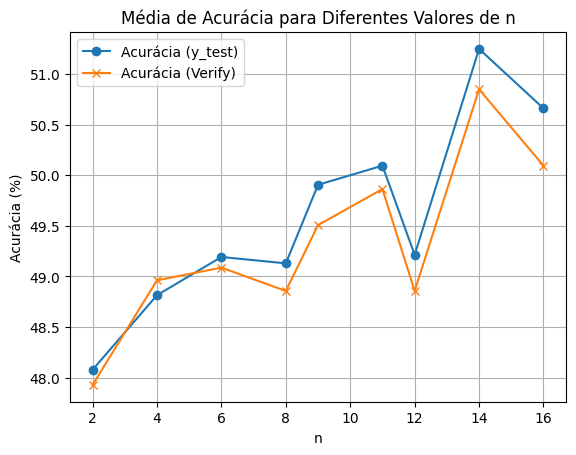

In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

for n in n_list:
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}_n{n}',
                    f'r_percent_{alpha:.2f}_n{n}',
                    f'Price_Rate_Of_Change_{alpha:.2f}_n{n}',
                    f'MACD_{alpha:.2f}_n{n}',
                    f'MACD_EMA_{alpha:.2f}_n{n}',
                    f'OBV_{alpha:.2f}_n{n}']]
    y = price_data[f'Prediction_{alpha:.2f}_n{n}']
    verify = price_data['Verify']

    # Concatenar e tratar NaN
    data = pd.concat([X, y, verify], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]


    # Converter para float32
    X = X.astype(np.float32)

    # Configurar TimeSeriesSplit e o resto do código
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()